# Description

In this notebook, we will train the Image Captioning model:
- Dataset: Flickr8k

In [1]:
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

from data_utils import *

/home/necphy/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# 1. Prepare dataset

## 1.1. Load dataset

In [2]:
PATH_FILE_CAPTION = 'data/captions.txt'
PATH_FOLDER_IMAGES = 'data/Images/'

In [3]:
# Read the captions
df = pd.read_csv(PATH_FILE_CAPTION)

# Building the vocab
vocab = Vocabulary(freq_threshold=1)

vocab.build_vocab(df.caption.values)
print(f"Number of words in the vocab: {len(vocab)}")

Number of words in the vocab: 8922


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.2914162].


Caption numerical: tensor([   1,    4,  191,    9, 1496,   83,    4, 3825,  170,   26,  440,   18,
           2])
Caption: <SOS> a person is swinging by a cord over the ocean . <EOS>


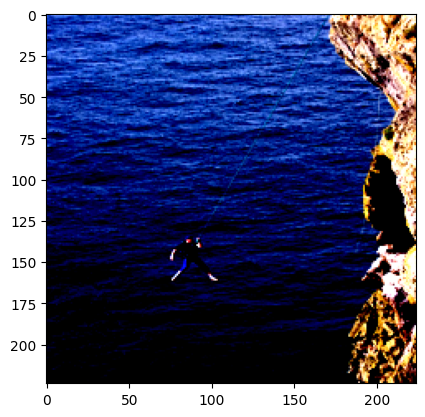

In [4]:
# Load the Custom Dataset
transform = transforms.Compose([
    transforms.Resize((226, 226)),
    transforms.RandomCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = FlickrDataset(df, vocab, path_folder_images=PATH_FOLDER_IMAGES, transform=transform)

display_random_image(dataset)

## 1.2. Prepare the Data Loader

In [5]:
BATH_SIZE = 8
NUM_WORKERS = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

padding_value = dataset.vocab.str_2_int['<PAD>']
data_loader = DataLoader(dataset, batch_size=BATH_SIZE, num_workers=NUM_WORKERS, shuffle=True, collate_fn=Collate(padding_value))

# 2. Define model architecture

- Model: seq2seq model. 
- Encoder: pretrained Mobile v3 model. 
- Decoder: Bahdanau Attention and LSTM cell.

In [6]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        # base_model = models.mobilenet_v3_small()
        # for param in base_model.parameters():
            # param.requires_grad_(False)
        # modules = list(base_model.children())[:-2]
        # self.base_model = nn.Sequential(*modules)
        
        self.base_model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 24, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(24, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
        )
        
        
    def forward(self, images):
        features = self.base_model(images)                                    # (batch_size, 32, 28, 28)
        features = features.permute(0, 2, 3, 1)                           # (batch_size, 28, 28, 32)
        features = features.view(features.size(0), -1, features.size(-1)) # (batch_size, 49, 576)
        return features
    
def calculate_number_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
test_image = torch.zeros((32, 3, 224, 224))
encoder = EncoderCNN()
test_output_encoder = encoder(test_image)

print(f"Test Output Shape: {test_output_encoder.shape}")
print(f"Number of parameters in the model: {calculate_number_parameters(encoder)}")

Test Output Shape: torch.Size([32, 36, 128])
Number of parameters in the model: 103224


In [8]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights

In [9]:
class Cross_Attention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(Cross_Attention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        
    def forward(self, x, context):
        attn_output, attn_output_weights = self.multihead_attn(x, context, context)
        return attn_output, attn_output_weights
    
class Masked_Attention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(Masked_Attention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        
    def forward(self, x):
        seq_len = x.size(1)
        attn_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)  # Upper triangular
        attn_mask = attn_mask.masked_fill(attn_mask == 1, float("-inf"))  # Convert to -inf for masking
        attn_mask = attn_mask.masked_fill(attn_mask == 0, float(0.0))     # Convert to 0 for allowed positions
        
        attn_output, attn_output_weights = self.multihead_attn(x, x, x, attn_mask=attn_mask)
        return attn_output, attn_output_weights
        

class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.d_model = d_model
        self.heads = heads
        self.d_ff = d_ff
        self.dropout = dropout
        
        self.masked_attn = Masked_Attention(d_model, heads)
        self.cross_attn = Cross_Attention(d_model, heads)
        
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.layernorm3 = nn.LayerNorm(d_model)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff * d_model),
            nn.ReLU(),
            nn.Linear(d_ff * d_model, d_model)
        )
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, encoder_output):
        
        # Masked Attention
        masked_attn_output, _ = self.masked_attn(x)
        x = self.layernorm1(x + self.dropout(masked_attn_output))
        
        # Cross Attention
        cross_attn_output, _ = self.cross_attn(x, encoder_output)
        x = self.layernorm2(x + self.dropout(cross_attn_output))
        
        # Feed Forward
        feed_forward_output = self.feed_forward(x)
        x = self.layernorm3(x + self.dropout(feed_forward_output))
        
        return x

class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, heads, d_ff, vocab_size, dropout):
        super().__init__()
        
        self.num_layers = num_layers
        self.d_model = d_model
        self.heads = heads
        self.d_ff = d_ff
        self.vocab_size = vocab_size
        self.dropout = dropout
        
        self.embedding = nn.Embedding(vocab_size, d_model)
        
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, heads, d_model, dropout) for _ in range(num_layers)])
           
    
    def forward(self, features, captions):
        
        x = self.embedding(captions)
        
        for layer in self.decoder_layers:
            x = layer(x, features)
        
        return x        
    
    def generate_caption(self, features, max_len=20, vocab=None):
        """
        This function generates captions for the given image features
        """
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        # starting input
        word = torch.tensor(vocab.str_2_int['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        captions = []
        
        for i in range(max_len):
            alpha, context = self.attention(features, h)
            
            # store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            # select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            # save the generated word
            captions.append(predicted_word_idx.item())
            
            # end if <EOS detected>
            if vocab.int_2_str[predicted_word_idx.item()] == "<EOS>":
                break
            
            # send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        # covert the vocab idx to words and return sentence
        return [vocab.int_2_str[idx] for idx in captions], alphas
    

In [10]:
decoder = Decoder(num_layers=2, d_model=128, heads=4, d_ff=256, vocab_size=len(vocab), dropout=0.1)

test_output_decoder = decoder(test_output_encoder, torch.randint(0, 100, (32, 16)))

print(f"Test Output Shape: {test_output_decoder.shape}")
print(f"Number of parameters in decoder: {calculate_number_parameters(decoder)}")

Test Output Shape: torch.Size([32, 16, 128])
Number of parameters in decoder: 9829376


In [11]:
class EncoderDecoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff , vocab_size, dropout):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = Decoder(num_layers, d_model, num_heads, d_ff, vocab_size, dropout=dropout)
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

# 3. Training 

In [12]:
# Hyperparams
num_layers = 2
d_model = 128
num_heads = 4
d_ff = 256
dropout = 0.1
learning_rate = 3e-4
vocab_size = len(dataset.vocab)

# Init model
model = EncoderDecoder(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    d_ff=d_ff,
    vocab_size=vocab_size,
    dropout=dropout
).to(device)
    
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.str_2_int["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
print(f"Number of parameters in the model: {calculate_number_parameters(model)}")

Number of parameters in the model: 9932600


In [14]:
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
num_epochs = 1
print_every = 3

for epoch in range(1, num_epochs+1):   
    for idx, (image, captions) in enumerate(iter(data_loader)):
        
        input_caption = captions[:, :-1]
        target_caption = captions[:, 1:]

        image, input_caption, target_caption = image.to(device), input_caption.to(device), target_caption.to(device)

        optimizer.zero_grad()

        outputs, attentions = model(image, input_caption)

        # Calculate the batch loss without the <START> token.
        loss = criterion(outputs.view(-1, vocab_size), target_caption.reshape(-1))
        
        loss.backward()
        optimizer.step()
        print("Epoch: {} loss: {:.5f}".format(epoch, loss.item()))

    # if epoch % print_every == 0:
    #     print("Epoch: {} loss: {:.5f}".format(epoch, loss.item()))
        
    #     # generate the caption
    #     model.eval()
    #     with torch.no_grad():
    #         dataiter = iter(data_loader)
    #         img,_ = next(dataiter)
    #         features = model.encoder(img[0:1].to(device))
    #         caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
    #         caption = ' '.join(caps)
    #         show_image(img[0],title=caption)
            
    #     model.train()

True
True


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument batch1 in method wrapper_CUDA_baddbmm)